## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import os
import numpy as np
import math
import scipy.stats as stats
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda, numba, int64, float64

In [2]:
#Since emulator has a bug we use target=parallel

@vectorize([float64(int64)], target='parallel', fastmath=True) 
def vec_exp(x):
    return pow(math.e,x)

@vectorize([float64(int64)], target='parallel', fastmath=True)
def vec_log(x):
    return math.log(x)

A = np.array([2, 5, 10, 3, 8], dtype='int64')
E = np.array([7.3890562e+00, 1.4841316e+02, 2.2026465e+04, 2.0085537e+01, 2.9809580e+03], dtype='float64')
L = np.array([0.6931472, 1.609438, 2.3025851, 1.0986123, 2.0794415], dtype='float64')

print(np.allclose(vec_exp(A),E))
print(np.allclose(vec_log(A),L))

True
True


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
#Non sono sicura di aver capito la consegna: vectorized functions? 

@vectorize([float64(float64)], target='parallel', fastmath=True) 
def gaussian_mean_1_vec(x):
    return pow(math.e,(-pow(x-1,2))/2.)*pow(2*math.pi,-(1./2.))

X = np.linspace(-3, 3, num=100000)
R = gaussian_mean_1_vec(X)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

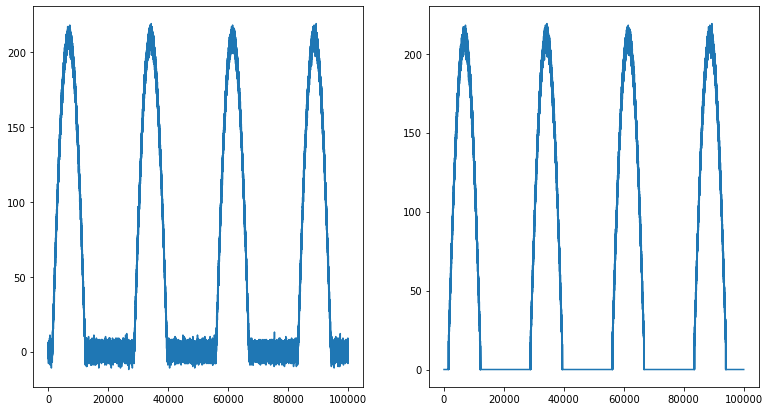

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,7))
ax1.plot(data)

@vectorize([float64(float64)], target='parallel', fastmath=True) 
def zero_suppress(x):
    if x<15:
        x=0
    return x

ax2.plot(zero_suppress(data))
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

#@vectorize([float64(float64,float64,float64,float64)], target='parallel', fastmath=True) 
#def sigmoid_kernel_vec(x,y,a,c):
    
def sigmoid_kernel_np(x,y,a,c):
    return np.tanh(a*np.matmul(x,y)+c)

r_np = sigmoid_kernel_np(X,Y,(1./9.),0.2)
print(r_np)

#Non sono riuscita a comprendere l'attinenza della consegna alle vectorized 
#functions, anche perché mi sembrano scomode per il prodotto riga per colonna.
#Se invece si trattasse di kernel functions, l'ultimo esercizio è già
#relativo al prodotto riga per colonna, mi sembrerebbe strano un doppione

[[0.24140582 0.36936747 0.28941106]
 [0.24864173 0.39905557 0.30597073]
 [0.24560755 0.36101494 0.29901896]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
@cuda.jit
def cos_kernel_3D(i_array, o_array):
    x_dim, y_dim, z_dim = cuda.grid(3)
    if x_dim < i_array.shape[0] and y_dim < i_array.shape[1] and z_dim < i_array.shape[2]:
        o_array[x_dim][y_dim][z_dim] = np.cos(i_array[x_dim][y_dim][z_dim])

#data = np.random.uniform(0, 2*np.pi, [256,256,256])
#result = np.zeros([256,256,256], dtype=np.float64)
data = np.random.uniform(0, 2*np.pi, [8,8,8])
result = np.zeros([8,8,8], dtype=np.float64)

#threadsperblock = (16,16,16)
threadsperblock = (2, 2, 2)  
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

cos_kernel_3D[blockspergrid, threadsperblock](data, result)
print(result)

#I couldn't use "the data = np.random.uniform(0, 2*np.pi, [256,256,256])"", because,
#as matteo migliorini said, there is a known problem with the cuda simulator in 
#numba that deals with memory and allocating blocks.

[[[ 0.01614177  0.43869714 -0.86294982 -0.96908832  0.43961879
    0.37530668 -0.95756867 -0.9968608 ]
  [ 0.23242519  0.97428053  0.35533364 -0.97100044 -0.47483148
   -0.1617944  -0.99393159  0.20125147]
  [-0.56720479 -0.33606458 -0.24688205 -0.14082351  0.9446749
    0.83014141  0.76299878 -0.99613294]
  [-0.96620548  0.77775469 -0.71567263  0.1992158   0.83116803
   -0.97625974 -0.90756258 -0.34248192]
  [ 0.22849085  0.52852293 -0.79906943 -0.9997988  -0.91477318
   -0.4995818  -0.99747871  0.56008565]
  [-0.01114097 -0.49808744  0.80638604  0.61897778 -0.28828811
   -0.90926214 -0.52415778 -0.6898757 ]
  [-0.99393299  0.99995487  0.80522873  0.45045108 -0.6991693
   -0.75261219  0.46360345 -0.69711271]
  [ 0.34357705  0.26521162 -0.17248988 -0.66484865  0.99881641
   -0.95429072 -0.88091789 -0.11777253]]

 [[ 0.40990907 -0.47715948 -0.42924658 -0.49974519 -0.92050005
    0.59589459 -0.98003828  0.16066034]
  [-0.60157655  0.98296098  0.62605904 -0.40795838  0.97153027
    0.8910

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [7]:
from __future__ import division
from numba import cuda
import numpy
import math

@cuda.jit(int64(int64, int64))
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(0, 10, [24,12], dtype='int64')
B = np.random.randint(0, 10, [12,22], dtype='int64')
C = np.zeros([24,22], dtype='int64')

# Configure the blocks
threadsperblock = (8,2)
blockspergrid_x = int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)
D = np.matmul(A,B)
print(np.allclose(C,D))

True
